In [1]:
# Importing necessary libraries
import os 
import random 
import pandas as pd 
from PIL import Image, ImageOps 
from torchvision import transforms 
from tqdm import tqdm 
import torch
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

In [2]:
# Creating a function for Data Augmentation (Malignant Images)
def augment_image(img_path, output_dir, base_name):
    
    img = Image.open(img_path)
    
    # 1. Saves Original image
    img.save(os.path.join(output_dir, f"{base_name}_original.jpg"))
    
    # 2. Flips the image Horizontally
    ImageOps.mirror(img).save(os.path.join(output_dir, f"{base_name}_horizontal.jpg"))
    
    # 3. Flips the image Vertically 
    ImageOps.flip(img).save(os.path.join(output_dir, f"{base_name}_vertical.jpg"))
    
    # 4. Crops the image focusing the centre
    cropped = transforms.CenterCrop((int(img.height * 0.9), int(img.width * 0.9)))(img)
    cropped.save(os.path.join(output_dir, f"{base_name}_crop.jpg"))
    
    # 5. Rotates the image in 45, 90, 135 degree angles
    for angle in [45, 90, 135]:
        rotated = img.rotate(angle)
        rotated.save(os.path.join(output_dir, f"{base_name}_rotate_{angle}.jpg"))


In [3]:
# My Data Paths
dataset_csv = r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\ISIC_2020_Training_GroundTruth_v2.csv'   
image_folder = r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\ISIC_2020_Training_JPEG\train'  
output_dir = r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\ISIC_2020_Training_JPEG\AugmentedMalignant'  

# Ensuring that the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loading the dataset
data = pd.read_csv(dataset_csv)

# Filtering the malignant images
malignant_images = data[data['target'] == 1]

# Applying the augmentations
for idx, row in tqdm(malignant_images.iterrows(), total=len(malignant_images)):
    img_name = os.path.join(image_folder, row['image_name'] + '.jpg')  # Assuming .jpg extension
    base_name = row['image_name']
    augment_image(img_name, output_dir, base_name)


100%|██████████| 584/584 [00:00<00:00, 9149.35it/s]


In [4]:
# Getting all the training images (original) along with the augmented malignant images
tr_images = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]

augmented_images = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if '_original' not in f]

# Creating malignant DataFrame with augmented images
augmented_data = pd.DataFrame({
    'image_name': [os.path.splitext(os.path.basename(f))[0] for f in augmented_images],
    'target': 1
})

# Converting tr_images (training images) to DataFrame
tr_images_df = pd.DataFrame({
    'image_name': [os.path.splitext(os.path.basename(f))[0] for f in tr_images],
    'target': 1  
})

# Selecting 3500 benign images
benign_images = data[data['target'] == 0].sample(3500, random_state=101)

# Combining tr_original (Original Images) + malignant and benign datasets
final_dataset = pd.concat([tr_images_df, benign_images]).reset_index(drop=True)

print("Done")


Done


In [5]:
# Removing specific columns from the dataset to focus more on the target column
columns_to_remove = [
    'patient_id', 
    'lesion_id', 
    'sex', 
    'age_approx', 
    'anatom_site_general_challenge', 
    'diagnosis', 
    'benign_malignant'
]

# Dropping the unwanted columns from the dataset
train_df = final_dataset.drop(columns=columns_to_remove)

# Checking the resulting dataframe
print(train_df.head())

# Save the dataframe as .csv
train_df.to_csv(r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\final_dataset.csv', index=False)


                image_name  target
0        ISIC_0149568_crop       1
1  ISIC_0149568_horizontal       1
2    ISIC_0149568_original       1
3  ISIC_0149568_rotate_135       1
4   ISIC_0149568_rotate_45       1


### MODEL TRAINING BEGINS

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Defining the directories
train_folder = r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\ISIC_2020_Training_JPEG\train'
augmented_folder = r'C:\Users\wecome\Desktop\College\Semester 2\Deep Learning with PyTorch\Project\Dataset\ISIC_2020_Training_JPEG\AugmentedMalignant' 

# Creating a function to retrieve the correct image path
def get_image_path(image_name, original_dir, augmented_dir):
    if "original" in image_name or not "rotate" in image_name:
        return os.path.join(original_dir, image_name + '.jpg')
    return os.path.join(augmented_dir, image_name + '.jpg')

# Adding file paths to the DataFrame
train_df['file_path'] = train_df['image_name'].apply(
    lambda x: get_image_path(x, train_folder, augmented_folder)
)


In [7]:

# Filtering out missing files
train_df = train_df[train_df['file_path'].apply(os.path.exists)]

# Loading images and labels
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  
    return img_array

train_df['image_array'] = train_df['file_path'].apply(load_and_preprocess_image)
X = np.stack(train_df['image_array'].values)
y = np.array(train_df['target'])

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:

# Augmenting the whole data to diversify the data during training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [9]:


# Converting labels to categoricals
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compiling the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=2  # Train for a fixed number of epochs
)

# Evaluating the model
val_loss, val_accuracy = model.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



c:\Users\wecome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2


c:\Users\wecome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 91s 658ms/step - accuracy: 0.8527 - loss: 0.3570 - val_accuracy: 0.9943 - val_loss: 0.0518
Epoch 2/2
132/132 ━━━━━━━━━━━━━━━━━━━━ 84s 626ms/step - accuracy: 0.9907 - loss: 0.0714 - val_accuracy: 0.9943 - val_loss: 0.0344
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9961 - loss: 0.0246
Validation Loss: 0.0344
Validation Accuracy: 0.9943


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Prediction on validation set
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5).astype(int)  

# Computing all three evaluation metrics Precision, Recall, and F1 Score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print results
print(f'Precision: {precision*100:.4f}')
print(f'Recall: {recall*100:.4f}')
print(f'F1 Score: {f1*100:.4f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Precision: 100.0000
Recall: 98.2906
F1 Score: 99.1379


In [15]:
from sklearn.metrics import classification_report

# Generating a classification report
report = classification_report(y_val, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       700
           1       1.00      0.98      0.99       351

    accuracy                           0.99      1051
   macro avg       1.00      0.99      0.99      1051
weighted avg       0.99      0.99      0.99      1051



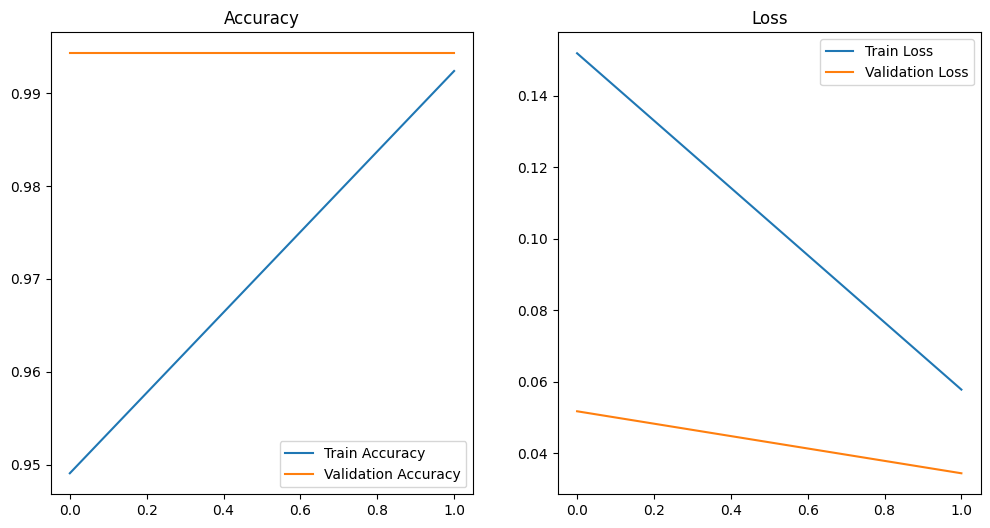

In [10]:

# Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


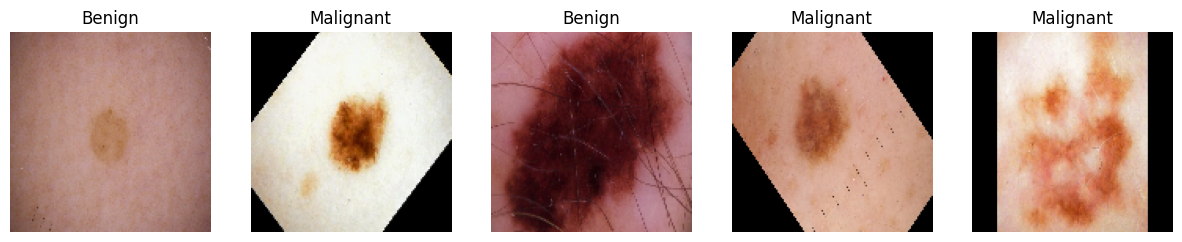

In [20]:
import matplotlib.pyplot as plt
import random

# Plotting random image samples from the dataset
def plot_image_samples(df, num_samples=5):
    sample_df = df.sample(n=num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for idx, (i, row) in enumerate(sample_df.iterrows()):
        img = row['image_array']
        label = 'Malignant' if row['target'] == 1 else 'Benign'
        axes[idx].imshow(img)
        axes[idx].set_title(label)
        axes[idx].axis('off')
    
    plt.show()

plot_image_samples(train_df, num_samples=5)


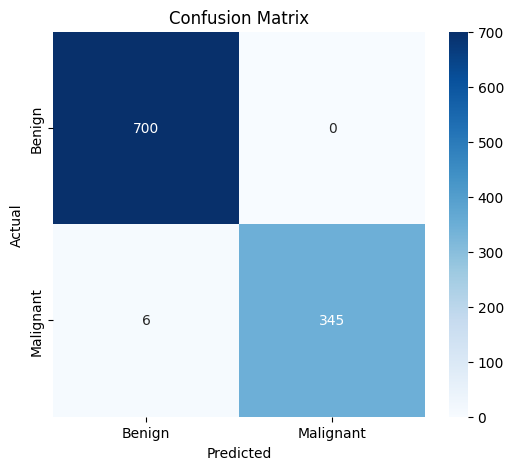

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Getting the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plotting the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

labels = ['Benign', 'Malignant']
plot_confusion_matrix(cm, labels)
